In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os
import plotly.express as px
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tabulate
import plotly.graph_objects as go
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances_argmin_min
from functools import reduce

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
os.chdir('..')

In [4]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.utils import missing_values_table, find_agg, convert_bytes_to_megabytes, fix_outlier, remove_outliers
from src.plot_utils import set_seaborn_style, plot_histogram_kde, plot_boxplot, plot_time_series, plot_countplot, create_table

In [5]:
db_connection = DatabaseConnection()
set_seaborn_style()

In [6]:
db_connection.connect()

Connected to the database.


In [7]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
# Relevant features for clustering
features = ['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

In [10]:
# Convert 'Start' and 'End' columns to datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

# Calculate session duration
df['Session Duration (ms)'] = (df['End'] - df['Start']).dt.total_seconds() * 1000

# Calculate total traffic for each session (download + upload)
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Group by 'MSISDN/Number' to calculate metrics for each user
user_engagement = df.groupby('MSISDN/Number').agg({
    'Start': 'count',                           # Sessions frequency
    'Session Duration (ms)': 'mean',           # Average session duration
    'Total Traffic (Bytes)': 'sum'             # Total traffic for all sessions
})

# Rename columns for better readability
user_engagement = user_engagement.rename(columns={
    'Start': 'Sessions Frequency',
    'Session Duration (ms)': 'Average Session Duration (ms)',
    'Total Traffic (Bytes)': 'Total Traffic (Bytes)'
})

# Display the result
print(user_engagement)

               Sessions Frequency  Average Session Duration (ms)  \
MSISDN/Number                                                      
3.360100e+10                    1                    116760000.0   
3.360100e+10                    1                    181260000.0   
3.360100e+10                    1                    135000000.0   
3.360101e+10                    1                     49920000.0   
3.360101e+10                    2                     18600000.0   
...                           ...                            ...   
3.379000e+10                    1                      8760000.0   
3.379000e+10                    1                    141000000.0   
3.197021e+12                    1                    877380000.0   
3.370000e+14                    1                    253020000.0   
8.823971e+14                    1                    869820000.0   

               Total Traffic (Bytes)  
MSISDN/Number                         
3.360100e+10            8.786906e+08 

In [11]:
# Normalize the engagement metrics
scaler = StandardScaler()
normalized_engagement = scaler.fit_transform(user_engagement)

# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(normalized_engagement)

# Display the results
print("Customers Classified into 3 Groups of Engagement:")
print(user_engagement)

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Customers Classified into 3 Groups of Engagement:
               Sessions Frequency  Average Session Duration (ms)  \
MSISDN/Number                                                      
3.360100e+10                    1                    116760000.0   
3.360100e+10                    1                    181260000.0   
3.360100e+10                    1                    135000000.0   
3.360101e+10                    1                     49920000.0   
3.360101e+10                    2                     18600000.0   
...                           ...                            ...   
3.379000e+10                    1                      8760000.0   
3.379000e+10                    1                    141000000.0   
3.197021e+12                    1                    877380000.0   
3.370000e+14                    1                    253020000.0   
8.823971e+14                    1                    869820000.0   

               Total Traffic (Bytes)  Cluster  
MSISDN/Number    

In [12]:
# Fit k-means with the selected number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(normalized_engagement)

# Determine which cluster has lower engagement based on, for example, 'Sessions Frequency'
less_engaged_cluster = user_engagement.groupby('Cluster')['Sessions Frequency'].mean().idxmin()

# Calculate Euclidean distances to the centroids
distances = pairwise_distances_argmin_min(normalized_engagement, kmeans.cluster_centers_)[1]

# Reset the index before accessing 'MSISDN/Number' column
user_engagement.reset_index(inplace=True)

# Assign engagement scores based on the less engaged cluster
user_engagement['Engagement Score'] = distances if less_engaged_cluster == 0 else -distances

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Display the results
print("Customers with Engagement Scores:")
print(user_engagement[['MSISDN/Number', 'Engagement Score']])

Customers with Engagement Scores:
        MSISDN/Number  Engagement Score
0        3.360100e+10          0.987749
1        3.360100e+10          0.780296
2        3.360100e+10          0.789995
3        3.360101e+10          0.383222
4        3.360101e+10          1.484564
...               ...               ...
106851   3.379000e+10          0.932555
106852   3.379000e+10          0.703592
106853   3.197021e+12          9.529468
106854   3.370000e+14          0.888410
106855   8.823971e+14          9.439091

[106856 rows x 2 columns]


In [14]:
# Group by customer and calculate the mean for both DL and UL throughput
grouped_data_throughput = df.groupby('MSISDN/Number').agg({
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# Treat missing values by replacing them with the mean
grouped_data_throughput['Avg Bearer TP DL (kbps)'].fillna(grouped_data_throughput['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
grouped_data_throughput['Avg Bearer TP UL (kbps)'].fillna(grouped_data_throughput['Avg Bearer TP UL (kbps)'].mean(), inplace=True)

# Display the resulting DataFrame
print(grouped_data_throughput)

        MSISDN/Number  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)
0        3.360100e+10                     37.0                     39.0
1        3.360100e+10                     48.0                     51.0
2        3.360100e+10                     48.0                     49.0
3        3.360101e+10                    204.0                     44.0
4        3.360101e+10                  20197.5                   8224.5
...               ...                      ...                      ...
106851   3.379000e+10                   9978.0                    387.0
106852   3.379000e+10                     68.0                     48.0
106853   3.197021e+12                      1.0                      0.0
106854   3.370000e+14                     11.0                     22.0
106855   8.823971e+14                      2.0                      0.0

[106856 rows x 3 columns]


In [15]:
grouped_data_rtt = df.groupby('MSISDN/Number')['Avg RTT DL (ms)'].mean().reset_index()

# Treat missing values by replacing them with the mean
grouped_data_rtt['Avg RTT DL (ms)'].fillna(grouped_data_rtt['Avg RTT DL (ms)'].mean(), inplace=True)

# Handling outliers (you can use a different method if needed)
mean_value_rtt = grouped_data_rtt['Avg RTT DL (ms)'].mean()
std_dev_rtt = grouped_data_rtt['Avg RTT DL (ms)'].std()

# Define a threshold for outliers (you can adjust this threshold)
outlier_threshold_rtt = 3

# Replace outliers with the mean value
grouped_data_rtt['Avg RTT DL (ms)'] = grouped_data_rtt['Avg RTT DL (ms)'].apply(
    lambda x: mean_value_rtt if abs(x - mean_value_rtt) > outlier_threshold_rtt * std_dev_rtt else x
)

# Display the resulting DataFrame
print(grouped_data_rtt)

        MSISDN/Number  Avg RTT DL (ms)
0        3.360100e+10        46.000000
1        3.360100e+10        30.000000
2        3.360100e+10       119.182869
3        3.360101e+10        69.000000
4        3.360101e+10        57.000000
...               ...              ...
106851   3.379000e+10        42.000000
106852   3.379000e+10        34.000000
106853   3.197021e+12       119.182869
106854   3.370000e+14       119.182869
106855   8.823971e+14       119.182869

[106856 rows x 2 columns]


In [16]:
grouped_data_retrans = df.groupby('MSISDN/Number')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()

# Treat missing values by replacing them with the mean
grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'].fillna(grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)

# Handling outliers (you can use a different method if needed)
mean_value = grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'].mean()
std_dev = grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'].std()

# Define a threshold for outliers (you can adjust this threshold)
outlier_threshold = 3

# Replace outliers with the mean value
grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'] = grouped_data_retrans['TCP DL Retrans. Vol (Bytes)'].apply(
    lambda x: mean_value if abs(x - mean_value) > outlier_threshold * std_dev else x
)

# Display the resulting DataFrame
print(grouped_data_retrans)

        MSISDN/Number  TCP DL Retrans. Vol (Bytes)
0        3.360100e+10                 1.685339e+07
1        3.360100e+10                 1.685339e+07
2        3.360100e+10                 1.685339e+07
3        3.360101e+10                 1.066000e+03
4        3.360101e+10                 9.349630e+06
...               ...                          ...
106851   3.379000e+10                 2.150440e+05
106852   3.379000e+10                 1.685339e+07
106853   3.197021e+12                 1.685339e+07
106854   3.370000e+14                 1.685339e+07
106855   8.823971e+14                 1.685339e+07

[106856 rows x 2 columns]


In [17]:
# Group by 'MSISDN/Number' and calculate the mode for 'Handset Type'
grouped_data_handset = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index()

# Group by 'Handset Type' and calculate the mean for 'TCP DL Retrans. Vol (Bytes)'
grouped_data_tcp = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()

# Merge the datasets on 'Handset Type'
merged_data = pd.merge(grouped_data_handset, grouped_data_tcp, on='Handset Type')

# Display the resulting DataFrame
print(merged_data)

        MSISDN/Number                                    Handset Type  \
0        3.360100e+10                  Huawei P20 Lite Huawei Nova 3E   
1        3.360126e+10                  Huawei P20 Lite Huawei Nova 3E   
2        3.360127e+10                  Huawei P20 Lite Huawei Nova 3E   
3        3.360128e+10                  Huawei P20 Lite Huawei Nova 3E   
4        3.360137e+10                  Huawei P20 Lite Huawei Nova 3E   
...               ...                                             ...   
106851   3.378689e+10  Huawei Mate 9 Pro Porsche Design Huawei Mate 9   
106852   3.378712e+10                     Ddm Brands Llc Andy 5El Lte   
106853   3.378853e+10                Vivo Mobile Comm. Vivo Vivo X21A   
106854   3.197021e+12                Quectel Wireless. Quectel Ec25-E   
106855   8.823971e+14                Quectel Wireless. Quectel Ec21-E   

        TCP DL Retrans. Vol (Bytes)  
0                      2.623121e+06  
1                      2.623121e+06  
2        

In [18]:
# Combine features from different DataFrames
consolidated_data = pd.merge(grouped_data_handset, grouped_data_retrans, on='MSISDN/Number')
consolidated_data = pd.merge(consolidated_data, grouped_data_rtt, on='MSISDN/Number')
consolidated_data = pd.merge(consolidated_data, grouped_data_throughput, on='MSISDN/Number')
consolidated_data = pd.merge(consolidated_data, user_engagement, on='MSISDN/Number')

print(consolidated_data.dtypes)


MSISDN/Number                    float64
Handset Type                      object
TCP DL Retrans. Vol (Bytes)      float64
Avg RTT DL (ms)                  float64
Avg Bearer TP DL (kbps)          float64
Avg Bearer TP UL (kbps)          float64
Sessions Frequency                 int64
Average Session Duration (ms)    float64
Total Traffic (Bytes)            float64
Cluster                            int32
Engagement Score                 float64
dtype: object


In [19]:
# Select features for clustering
features_for_clustering = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

# Drop rows with missing values in the columns used for clustering
consolidated_data.dropna(subset=features_for_clustering, inplace=True)

# Standardize features
scaler = StandardScaler()
consolidated_data_scaled = scaler.fit_transform(consolidated_data[features_for_clustering])

# Choose the number of clusters (you may need to tune this)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
consolidated_data['cluster'] = kmeans.fit_predict(consolidated_data_scaled)

# Calculate Euclidean distance for each user
consolidated_data['euclidean_distance'] = consolidated_data.apply(
    lambda row: distance.euclidean(row[features_for_clustering], kmeans.cluster_centers_[row['cluster']]),
    axis=1
)

# Assign experience scores
consolidated_data['experience_score'] = 1 / (1 + consolidated_data['euclidean_distance'])

# Display the resulting DataFrame with experience scores
print(consolidated_data[['MSISDN/Number', 'experience_score']])


C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


        MSISDN/Number  experience_score
0        3.360100e+10      5.933523e-08
1        3.360100e+10      5.933523e-08
2        3.360100e+10      5.933523e-08
3        3.360101e+10      9.178681e-04
4        3.360101e+10      1.069558e-07
...               ...               ...
106851   3.379000e+10      4.645184e-06
106852   3.379000e+10      5.933523e-08
106853   3.197021e+12      5.933523e-08
106854   3.370000e+14      5.933523e-08
106855   8.823971e+14      5.933523e-08

[106856 rows x 2 columns]


In [20]:
# Calculate satisfaction score as the average of engagement and experience scores
consolidated_data['satisfaction_score'] = (user_engagement['Engagement Score'] + consolidated_data['experience_score']) / 2

# Sort the DataFrame by satisfaction score in descending order
top_satisfied_customers = consolidated_data.sort_values(by='satisfaction_score', ascending=False)

# Display the top 10 satisfied customers
top_10_satisfied_customers = top_satisfied_customers.head(10)
print("Top 10 Satisfied Customers:")
print(top_10_satisfied_customers[['MSISDN/Number', 'satisfaction_score']])


Top 10 Satisfied Customers:
       MSISDN/Number  satisfaction_score
13180   3.362578e+10           13.248600
6437    3.361489e+10           12.042311
13526   3.362632e+10           11.824005
92923   3.376054e+10           11.011010
37052   3.365973e+10           10.407605
76363   3.367588e+10           10.109175
71556   3.366926e+10            9.573468
45295   3.366172e+10            8.933542
1998    3.360750e+10            8.895862
65118   3.366716e+10            8.570207


In [21]:
consolidated_data

,MSISDN/Number,Handset Type,TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Sessions Frequency,Average Session Duration (ms),Total Traffic (Bytes),Cluster,Engagement Score,cluster,euclidean_distance,experience_score,satisfaction_score
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,1.685339e+07,46.000000,37.0,39.0,1,116760000.0,8.786906e+08,1,0.987749,0,1.685339e+07,5.933523e-08,0.493874
1,3.360100e+10,Apple iPhone 7 (A1778),1.685339e+07,30.000000,48.0,51.0,1,181260000.0,1.568596e+08,0,0.780296,0,1.685339e+07,5.933523e-08,0.390148
2,3.360100e+10,undefined,1.685339e+07,119.182869,48.0,49.0,1,135000000.0,5.959665e+08,0,0.789995,0,1.685339e+07,5.933523e-08,0.394998
3,3.360101e+10,Apple iPhone 5S (A1457),1.066000e+03,69.000000,204.0,44.0,1,49920000.0,4.223207e+08,1,0.383222,0,1.088481e+03,9.178681e-04,0.192070
4,3.360101e+10,Apple iPhone Se (A1723),9.349630e+06,57.000000,20197.5,8224.5,2,18600000.0,1.457411e+09,2,1.484564,1,9.349656e+06,1.069558e-07,0.742282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106851,3.379000e+10,Huawei Honor 9 Lite,2.150440e+05,42.000000,9978.0,387.0,1,8760000.0,7.146416e+08,1,0.932555,0,2.152757e+05,4.645184e-06,0.466280
106852,3.379000e+10,Apple iPhone 8 Plus (A1897),1.685339e+07,34.000000,68.0,48.0,1,141000000.0,4.803073e+08,0,0.703592,0,1.685339e+07,5.933523e-08,0.351796
106853,3.197021e+12,Quectel Wireless. Quectel Ec25-E,1.685339e+07,119.182869,1.0,0.0,1,877380000.0,2.321240e+08,0,9.529468,0,1.685339e+07,5.933523e-08,4.764734
106854,3.370000e+14,Huawei B525S-23A,1.685339e+07,119.182869,11.0,22.0,1,253020000.0,5.962878e+08,0,0.888410,0,1.685339e+07,5.933523e-08,0.444205


In [22]:
# Select features for the regression model
regression_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
regression_data = consolidated_data.dropna(subset=regression_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    regression_data[regression_features],
    regression_data['satisfaction_score'],
    test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Ridge regression model with regularization parameter alpha
model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)

# Train the model on the training set
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

consolidated_data['predicted_satisfaction_score'] = model.predict(consolidated_data[regression_features])

print(consolidated_data[['MSISDN/Number', 'satisfaction_score', 'predicted_satisfaction_score']])
print(f'Cross-validated R-squared scores: {cv_scores}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

        MSISDN/Number  satisfaction_score  predicted_satisfaction_score
0        3.360100e+10            0.493874                      0.837698
1        3.360100e+10            0.390148                      0.759534
2        3.360100e+10            0.394998                      0.763189
3        3.360101e+10            0.192070                      0.609925
4        3.360101e+10            0.742282                      1.024888
...               ...                 ...                           ...
106851   3.379000e+10            0.466280                      0.816902
106852   3.379000e+10            0.351796                      0.730634
106853   3.197021e+12            4.764734                      4.056041
106854   3.370000e+14            0.444205                      0.800269
106855   8.823971e+14            4.719545                      4.021989

[106856 rows x 3 columns]
Cross-validated R-squared scores: [1. 1. 1. 1. 1.]
Mean Squared Error: 1.678952628648227e-13
R-squared: 0.999

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


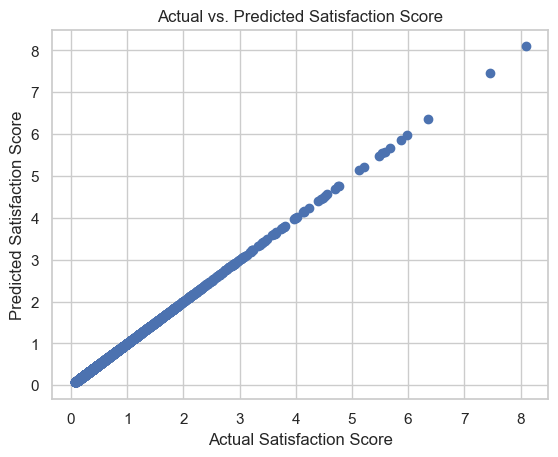

In [23]:
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Satisfaction Score')
plt.ylabel('Predicted Satisfaction Score')
plt.title('Actual vs. Predicted Satisfaction Score')
plt.show()

In [24]:
# Perform cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-validated R-squared scores: {scores}')

Cross-validated R-squared scores: [1. 1. 1. 1. 1.]


In [25]:
# Select features for the regression model
regression_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
regression_data = consolidated_data.dropna(subset=regression_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    regression_data[regression_features],
    regression_data['satisfaction_score'],
    test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

consolidated_data['predicted_satisfaction_score'] = model.predict(consolidated_data[regression_features])

print(consolidated_data[['MSISDN/Number', 'satisfaction_score', 'predicted_satisfaction_score']])

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-validated R-squared scores: {cv_scores}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

        MSISDN/Number  satisfaction_score  predicted_satisfaction_score
0        3.360100e+10            0.493874                      0.493876
1        3.360100e+10            0.390148                      0.390148
2        3.360100e+10            0.394998                      0.394997
3        3.360101e+10            0.192070                      0.191641
4        3.360101e+10            0.742282                      0.742281
...               ...                 ...                           ...
106851   3.379000e+10            0.466280                      0.466282
106852   3.379000e+10            0.351796                      0.351796
106853   3.197021e+12            4.764734                      4.766209
106854   3.370000e+14            0.444205                      0.444208
106855   8.823971e+14            4.719545                      4.724159

[106856 rows x 3 columns]
Cross-validated R-squared scores: [0.99935569 0.99990636 0.99996155 0.99998868 0.99908807]
Mean Squared Error

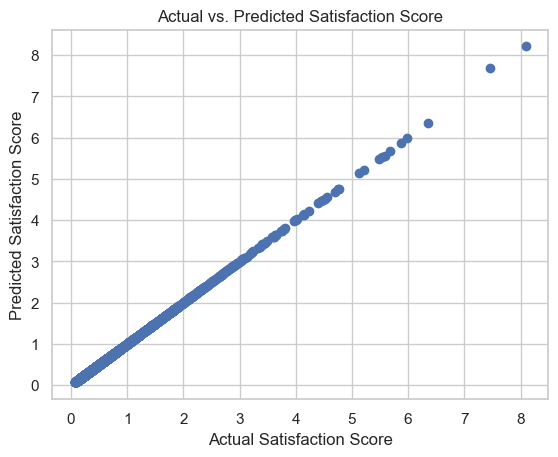

In [26]:
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Satisfaction Score')
plt.ylabel('Predicted Satisfaction Score')
plt.title('Actual vs. Predicted Satisfaction Score')
plt.show()

In [27]:
# Select features for the regression model
regression_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
regression_data = consolidated_data.dropna(subset=regression_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    regression_data[regression_features],
    regression_data['satisfaction_score'],
    test_size=0.2, random_state=42
)

# Initialize the Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

consolidated_data['predicted_satisfaction_score'] = model.predict(consolidated_data[regression_features])

print(consolidated_data[['MSISDN/Number', 'satisfaction_score', 'predicted_satisfaction_score']])

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-validated R-squared scores: {cv_scores}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

        MSISDN/Number  satisfaction_score  predicted_satisfaction_score
0        3.360100e+10            0.493874                      0.496683
1        3.360100e+10            0.390148                      0.391145
2        3.360100e+10            0.394998                      0.392613
3        3.360101e+10            0.192070                      0.190939
4        3.360101e+10            0.742282                      0.742264
...               ...                 ...                           ...
106851   3.379000e+10            0.466280                      0.470152
106852   3.379000e+10            0.351796                      0.349969
106853   3.197021e+12            4.764734                      4.751847
106854   3.370000e+14            0.444205                      0.445834
106855   8.823971e+14            4.719545                      4.737426

[106856 rows x 3 columns]
Cross-validated R-squared scores: [0.99904339 0.9997445  0.99964255 0.99982489 0.99921969]
Mean Squared Error

In [28]:
# Select features for k-means clustering
clustering_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
clustering_data = consolidated_data.dropna(subset=clustering_features)

# Standardize features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data[clustering_features])

# Run k-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Display the results
print("Results of K-means Clustering (k=2):")
print(clustering_data[['MSISDN/Number', 'Engagement Score', 'experience_score', 'cluster']])

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Results of K-means Clustering (k=2):
        MSISDN/Number  Engagement Score  experience_score  cluster
0        3.360100e+10          0.987749      5.933523e-08        0
1        3.360100e+10          0.780296      5.933523e-08        0
2        3.360100e+10          0.789995      5.933523e-08        0
3        3.360101e+10          0.383222      9.178681e-04        0
4        3.360101e+10          1.484564      1.069558e-07        0
...               ...               ...               ...      ...
106851   3.379000e+10          0.932555      4.645184e-06        0
106852   3.379000e+10          0.703592      5.933523e-08        0
106853   3.197021e+12          9.529468      5.933523e-08        0
106854   3.370000e+14          0.888410      5.933523e-08        0
106855   8.823971e+14          9.439091      5.933523e-08        0

[106856 rows x 4 columns]


In [29]:
# Select features for k-means clustering
clustering_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
clustering_data = consolidated_data.dropna(subset=clustering_features)

# Standardize features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data[clustering_features])

# Run k-means clustering with k=2
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Display the results
print("Results of K-means Clustering (k=2):")
print(clustering_data[['MSISDN/Number', 'Engagement Score', 'experience_score', 'cluster']])

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Results of K-means Clustering (k=2):
        MSISDN/Number  Engagement Score  experience_score  cluster
0        3.360100e+10          0.987749      5.933523e-08        0
1        3.360100e+10          0.780296      5.933523e-08        0
2        3.360100e+10          0.789995      5.933523e-08        0
3        3.360101e+10          0.383222      9.178681e-04        0
4        3.360101e+10          1.484564      1.069558e-07        0
...               ...               ...               ...      ...
106851   3.379000e+10          0.932555      4.645184e-06        0
106852   3.379000e+10          0.703592      5.933523e-08        0
106853   3.197021e+12          9.529468      5.933523e-08        2
106854   3.370000e+14          0.888410      5.933523e-08        0
106855   8.823971e+14          9.439091      5.933523e-08        2

[106856 rows x 4 columns]


In [30]:
# Select features for k-means clustering
clustering_features = ['Engagement Score', 'experience_score']

# Drop rows with missing values in the selected features
clustering_data = consolidated_data.dropna(subset=clustering_features)

# Standardize features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data[clustering_features])

# Run k-means clustering with k=2
kmeans = KMeans(n_clusters=4, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Display the results
print("Results of K-means Clustering (k=2):")
print(clustering_data[['MSISDN/Number', 'Engagement Score', 'experience_score', 'cluster']])

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Results of K-means Clustering (k=2):
        MSISDN/Number  Engagement Score  experience_score  cluster
0        3.360100e+10          0.987749      5.933523e-08        2
1        3.360100e+10          0.780296      5.933523e-08        2
2        3.360100e+10          0.789995      5.933523e-08        2
3        3.360101e+10          0.383222      9.178681e-04        2
4        3.360101e+10          1.484564      1.069558e-07        1
...               ...               ...               ...      ...
106851   3.379000e+10          0.932555      4.645184e-06        2
106852   3.379000e+10          0.703592      5.933523e-08        2
106853   3.197021e+12          9.529468      5.933523e-08        3
106854   3.370000e+14          0.888410      5.933523e-08        2
106855   8.823971e+14          9.439091      5.933523e-08        3

[106856 rows x 4 columns]


In [31]:
# Group by the 'cluster' column and calculate the mean for 'satisfaction_score' and 'experience_score'
cluster_aggregation = clustering_data.groupby('cluster').agg({
    'satisfaction_score': 'mean',
    'experience_score': 'mean'
}).reset_index()

# Display the aggregated results
print("Average Scores per Cluster:")
print(cluster_aggregation)

Average Scores per Cluster:
   cluster  satisfaction_score  experience_score
0        0            0.490507          0.004726
1        1            0.699885          0.000038
2        2            0.328399          0.000020
3        3            2.602254          0.000012


In [47]:
# Define the SQL query for creating the table
create_table_query = """
CREATE TABLE user_scores (
    user_id VARCHAR(255),
    engagement_score FLOAT,
    experience_score FLOAT,
    satisfaction_score FLOAT
);
"""

In [48]:
# Execute the query
db_connection.execute_query(create_table_query)

Error executing query: This Connection is closed


In [49]:
user_scores_df = consolidated_data[['MSISDN/Number', 'Engagement Score', 'experience_score', 'satisfaction_score']]

In [50]:
# Insert data into the 'user_scores' table
user_scores_df.to_sql('user_scores', con=db_connection.engine, index=False, if_exists='append')

# Close the database connection
db_connection.close_connection()

Connection closed.
